# The many faces of the Reverend Bayes: Face 1 Revisited

---

## ...starting from Face 2 and seeing the  connection...

$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Linear regression in 1D

The goal is to fit a straight line: 

$$ y = ax+b+\epsilon$$

where $\epsilon \sim N(0, \sigma)$
and predict $y$ at various $x$'s. 

Let ${\bf x} =(x_1, x_2, \ldots, x_n)$  and
$ {\bf y} =(y_1, y_2, \ldots, y_n)$ are the actual data. 

Using Bayesian formalism, we want to estimate the posteriors of the parameter
$\theta =a$ assuming $b=0$. 

We use  priors $a \sim N(0, \sigma_a)$.

 
The implementation below estimates the posterior using Bayes rule  and also samples 
directly from the product of the likelihood (same as the one in the MLE section above) and prior using the rejection method. 

Using priors with mean 0 and $\sigma_a^2=4$. $a \sim N(0, \sigma_a)$

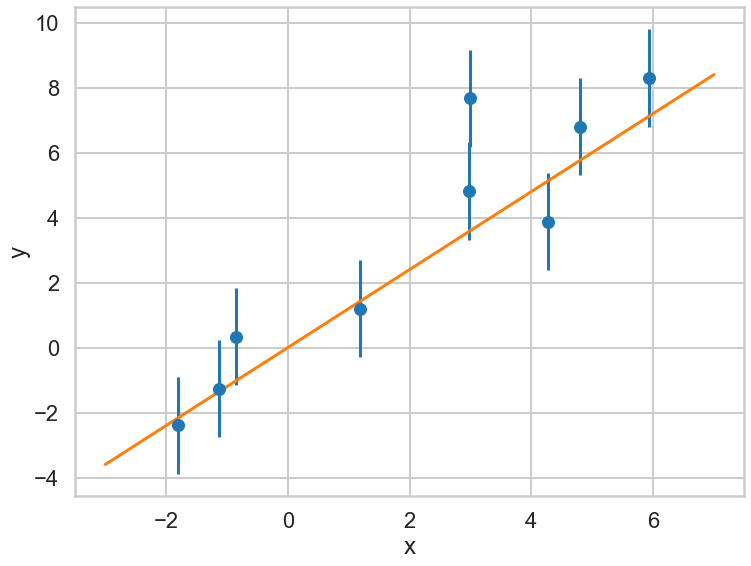

In [2]:
## GENERATE SYNTHETIC DATA
n=9
a = 1.2 # SLOPE
b = 0 # INTERSECTION 

s = 1.5 # STD OF ERROR 

x = np.random.uniform(low=-3, high=7, size=n) 
y = a*x+ b + s*np.random.randn(n)


#plt.subplot(2,2,2) 
plt.figure(figsize=(12,9))
plt.errorbar(x,y, yerr=s, fmt='o')
plt.xlabel('x')
plt.ylabel('y')

xr = np.linspace(-3, 7, 100) 
plt.plot(xr, a*xr)

We plot the prior and the likelihood.

Text(0.5, 1.0, 'Prior for a')

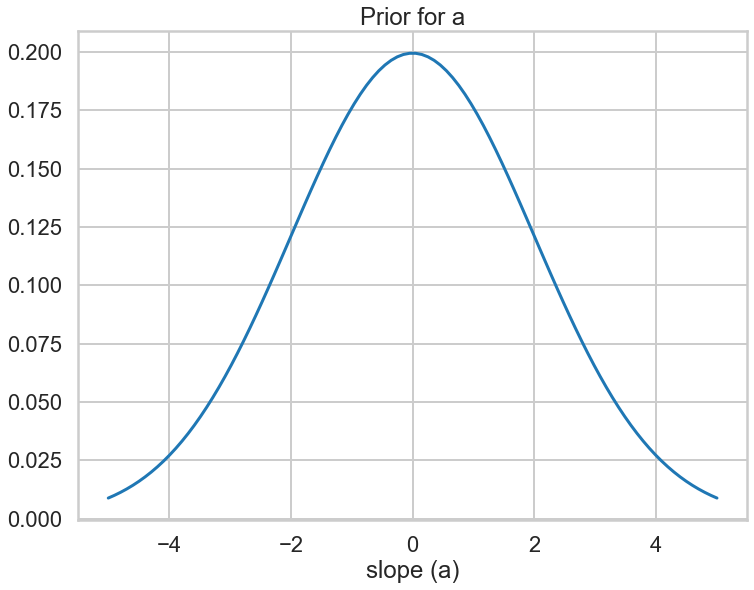

In [3]:
# ======================================
## PLOT THE PDF (probability density function) OF THE PRIOR
# ======================================
I = np.eye(2)

## PRIOR 
sig2 = 4   # WIDTH OF THE PRIOR

p_w = lambda w : (1/np.sqrt(2*np.pi*sig2))*np.exp( - (w**2)/(2*sig2))

asp = np.linspace(-5,5, 100)

P=p_w(asp)

plt.figure(figsize=(12,9))
plt.plot(asp, P)
plt.xlabel('slope (a)')
plt.title('Prior for a')

Note that the product in the gaussians is taken into the exponential as a sum.

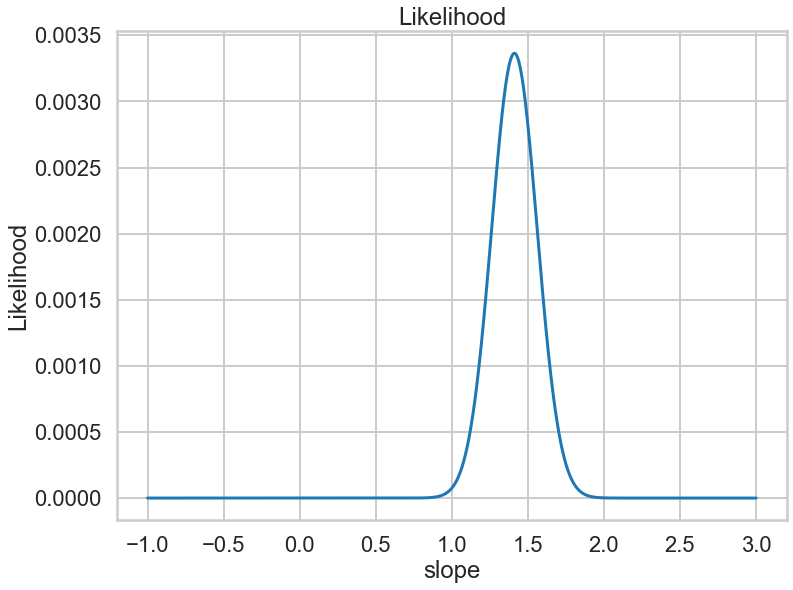

In [4]:
N=1000
asp = np.linspace(-1,3, N)

p_l = lambda asp : (1/np.sqrt(2*np.pi*s**2))*np.exp( - (np.sum( x*x*(y/x-asp)**2)/(2*s**2)))

P=np.zeros(N)

for k in np.arange(0, asp.size):
    P[k] = p_l(asp[k])


#plt.subplot(2,2,1)
plt.figure(figsize=(12,9))
plt.plot(asp, P)
plt.xlabel('slope')
plt.ylabel('Likelihood')

plt.title('Likelihood');

### Sampling for posterior

We use a Monte-Carlo method, rejection sampling, to sample from the posterior..we sample a box around it and reject all those samples that dont fall below the curve.

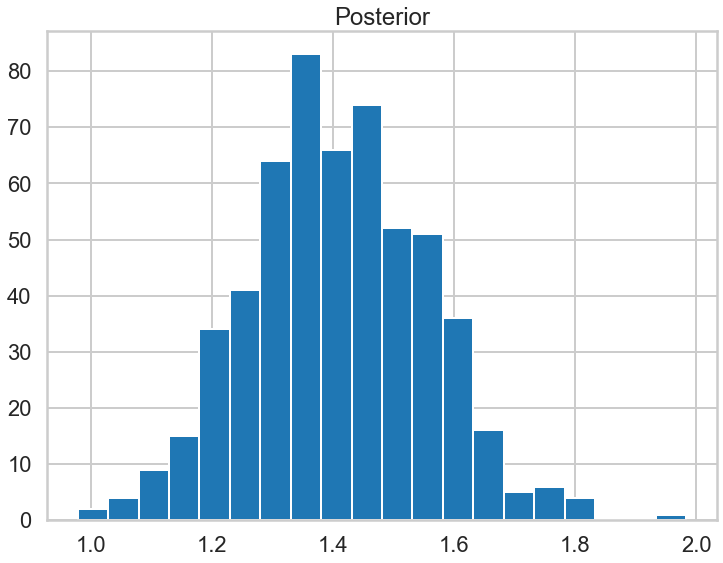

In [5]:
N=30000
asp = np.random.uniform(low=-10, high=10, size=N)



post = lambda wsp: p_l(wsp) * p_w(wsp) 

ptr = np.zeros(N)

for k in np.arange(0, N):
    ptr[k]= post(asp[k]) 


ysp =  np.random.uniform(low=0, high=np.max(ptr), size=N)
    
idx = (ysp<ptr)

plt.figure(figsize=(12,9))
g=plt.hist(asp[idx], 20);

plt.title('Posterior');

We didnt need to do this here because the posterior is a gaussian, but in real life, most posteriors are not conjugates. And they dont have closed forms. We then need to sample in some fashion. Here we used rejection sampling, but we could equally well use MCMC, etc.

## The Bayesian formulation of regression and the posterior predictive distribution

(taken from Am207 class notes)

In the linear regression model we have data $D$, of $n$ observations  
$D=\left\{ ({\bf x}_1, y_1), ({\bf x}_2,y_2), \ldots, ({\bf x}_n, y_n) \right\} $ where ${\bf x}$ 
denotes an input vector of dimension $D$ and $y$ denotes a scalar output (dependent variable). 
All data points are combined into a $D \times n$ matrix $X$. 
The model that determines the relationship between inputs and 
output is given by

$$ y   = \bf x^{T} {\bf w} + \epsilon $$

where ${\bf w}$ is a vector of parameters of the linear model. Usually there is 
a bias or offset is included, but for now we ignore it. 

We assume that the additive noise  $\epsilon$ is iid Gaussian with
zero mean and variance $\sigma_n^2$ 

$$ \epsilon \sim N(0, \sigma^2_n) $$

### Likelihood

The likelihood is, because we assume independency, the product 

\begin{eqnarray} L &=& p(\bf y|X,\bf w) = \prod_{i=1}^{n} p(y_i|\bf X_i, \bf w) = \frac{1}{\sqrt{2\pi}\sigma_n}  \prod_{i=1}^{n} 
   \exp{ \left( -\frac{(y_i-\bf X_i^T \bf w)^2}{2\sigma_n^2} \right)}  \nonumber \\ 
   &=& \frac{1}{\sqrt{2\pi}\sigma_n} \exp{\left( -\frac{| \bf y-X^T \bf w|^2 }{2\sigma_n^2} \right)} = N(X^T \bf w,  \sigma_n^2 I)
   \end{eqnarray}
   
where $|x|$ denotes the Euclidean length of vector $\bf x$. 

An alternative way of expressing the likelihood, which is convenient
when sampling ${\bf w}$'s:

\begin{eqnarray} 
p(\bf y|\bf X,\bf w) &=& \frac{1}{\sqrt{2\pi}\sigma_n} \exp{\left( -\frac{| X^{-1} \bf y- \bf w|^2 \,\, (X^{-1} (X^{-1})^{T}) }{2\sigma_n^2} \right)} = N(X^{-1} \bf y,  \sigma_n^2 (X^{-1} (X^{-1})^{T}) )
   \end{eqnarray}

### Prior

In the Bayesian framework inference we need to specify a prior
over the parameters that expresses our belief about the parameters
before we take any measurements. A wise choice is a zero mean 
Gaussian with covariance matrix $\Sigma$ 

\begin{equation}
 \bf w \sim N(0, \Sigma) 
\end{equation}


### Posterior
We can now continue with the standard Bayesian formalism 

\begin{eqnarray}
 p(\bf w| \bf y,X) &\propto& p(\bf y | X, \bf w) \, p(\bf w) \nonumber \\
                       &\propto& \exp{ \left(- \frac{1}{2 \sigma_n^2}(\bf y-X^T \bf w)^T(\bf y - X^T \bf w) \right)}
                        \exp{\left( -\frac{1}{2} \bf w^T \Sigma^{-1} \bf w \right)}  \nonumber \\ 
 \end{eqnarray}
 
In the next step we `complete the square' and obtain 

\begin{equation}
p(\bf w| \bf y,X)  \propto  \exp \left( -\frac{1}{2} (\bf w - \bar{\bf w})^T  (\frac{1}{\sigma_n^2} X X^T + \Sigma^{-1})(\bf w - \bar{\bf w} )  \right)
\end{equation}

where $\bar{\bf w} = \sigma_n^{-2}( \sigma_n^{-2}XX^T +\Sigma^{-1})^{-1} X \bf y $

This looks like a Gaussian and therefore the posterior is

$$ p(\bf w| X, {\bf y}) \sim {\cal N}( \frac{1}{\sigma_n^2} A^{-1}Xy , A^{-1} ) $$ 

where $A= \sigma_n^{-2}XX^T +\Sigma^{-1}$

To make predictions for a test case we average over all possible parameter predictive distribution
values, weighted by their posterior probability. This is in contrast to non Bayesian schemes, where a single parameter is typically chosen by some criterion. 

### Regularization

If we assume that $\Sigma$ is a diagonal covariance matrix so that

$$\bf w \sim N(0, \alpha \bf I)$$

then we get back alpha as the regularization parameter from ridge regression, since our "estimation risk" is just the log of the gaussian, and terms in exponents add!!

Similarly Lasso comes from a laplace prior.

### Posterior Predictive Distribution

Thus the predictive distribution at some $x^{*}$ is given by averaging the output of all possible linear models w.r.t. the  posterior

\begin{eqnarray} 
p(y^{*} | x^{*}, {\bf x,y}) &=& \int p({\bf y}^{*}| {\bf x}^{*}, {\bf w} ) p(\bf w| X, y)dw \nonumber \\
                                    &=& {\cal N} \left(\frac{1}{\sigma_n^2} x^{*^{T}} A^{-1} X {\bf y}, x^{*^T}A^{-1}x^{*} \right),
\end{eqnarray}

which is again Gaussian, with a mean given by the posterior mean multiplied by the test input
and the variance is a quadratic
form of the test input with the posterior covariance matrix, showing that the
predictive uncertainties grow with the magnitude of the test input, as one would
expect for a linear model. 

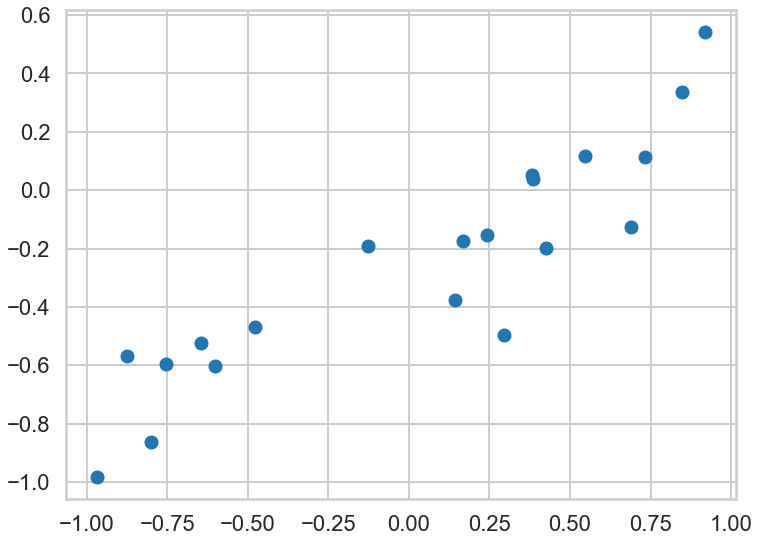

In [6]:
a0=-0.3
a1=0.5
N=20
noiseSD=0.2
priorPrecision=2.0
u=np.random.rand(20)
x=2.*u -1.
def randnms(mu, sigma, n):
    return sigma*np.random.randn(n) + mu
y=a0+a1*x+randnms(0.,noiseSD,N)
plt.figure(figsize=(12,9))
plt.scatter(x,y)

In [7]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
def cplot(f, ax=None):
    if not ax:
        plt.figure()
        ax=plt.gca()
    xx,yy=np.mgrid[-1:1:.01,-1:1:.01]
    pos = np.empty(xx.shape + (2,))
    pos[:, :, 0] = xx
    pos[:, :, 1] = yy
    ax.contourf(xx, yy, f(pos))
    #data = [x, y]
    return ax
def plotSampleLines(mu, sigma, numberOfLines, dataPoints=None, ax=None):
    #Plot the specified number of lines of the form y = w0 + w1*x in [-1,1]x[-1,1] by
    # drawing w0, w1 from a bivariate normal distribution with specified values
    # for mu = mean and sigma = covariance Matrix. Also plot the data points as
    # blue circles. 
    #print "datap",dataPoints
    if not ax:
        plt.figure(figsize=(12,9))
        ax=plt.gca()
    for i in range(numberOfLines):
        w = np.random.multivariate_normal(mu,sigma)
        func = lambda x: w[0] + w[1]*x
        xx=np.array([-1,1])
        ax.plot(xx,func(xx),'r', alpha=0.5)
    if dataPoints:
        ax.scatter(dataPoints[0],dataPoints[1])
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])


In [8]:
likelihoodSD = noiseSD # Assume the likelihood precision, beta, is known.
likelihoodPrecision = 1./(likelihoodSD*likelihoodSD)
priorMean = np.zeros(2)
priorSigma = np.eye(2)/priorPrecision #Covariance Matrix
priorPDF = lambda w: multivariate_normal.pdf(w,priorMean,priorSigma)
priorPDF([1,2])

0.0021447551423913074

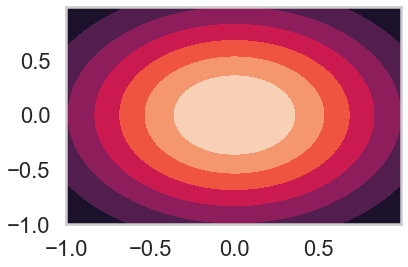

In [24]:
# shows the prior
cplot(priorPDF);

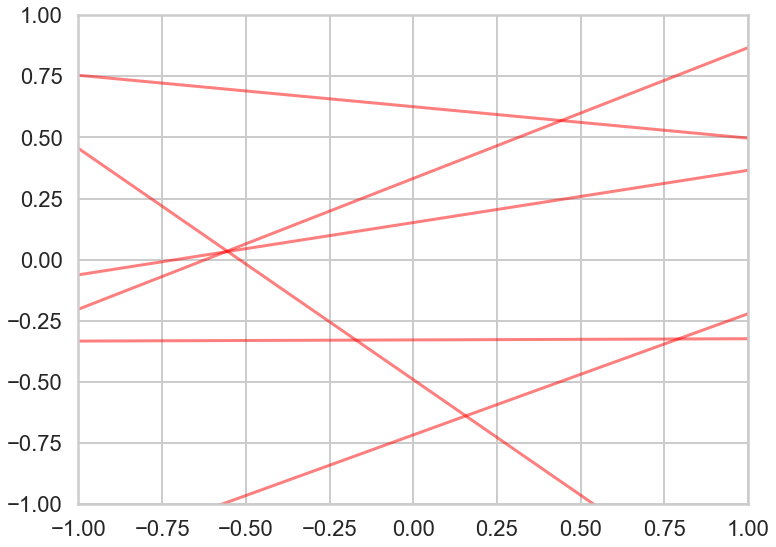

In [9]:
plotSampleLines(priorMean,priorSigma,6)

In [10]:
# Given the mean = priorMu and covarianceMatrix = priorSigma of a prior
# Gaussian distribution over regression parameters; observed data, xtrain
# and ytrain; and the likelihood precision, generate the posterior
# distribution, postW via Bayesian updating and return the updated values
# for mu and sigma. xtrain is a design matrix whose first column is the all
# ones vector.
def update(x,y,likelihoodPrecision,priorMu,priorSigma): 
    postSigmaInv  = np.linalg.inv(priorSigma) + likelihoodPrecision*np.outer(x.T,x)
    postSigma = np.linalg.inv(postSigmaInv)
    postMu = np.dot(np.dot(postSigma,np.linalg.inv(priorSigma)),priorMu) + likelihoodPrecision*np.dot(postSigma,np.outer(x.T,y)).flatten()
    postW = lambda w: multivariate_normal.pdf(w,postMu,postSigma)
    return postW,postMu,postSigma

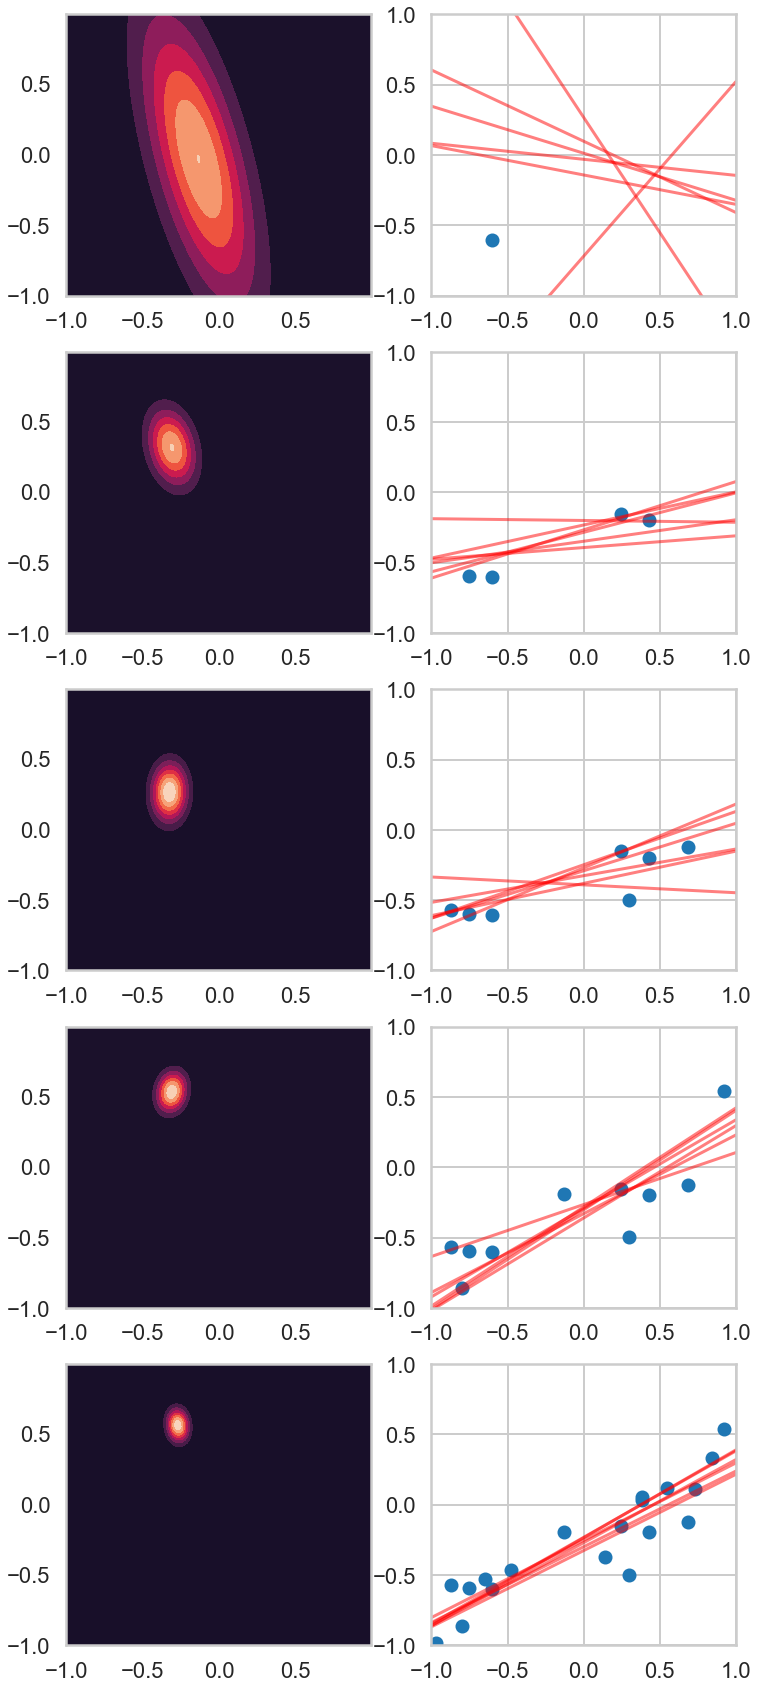

In [11]:
# For each iteration plot  the
# posterior over the first i data points and sample lines whose
# parameters are drawn from the corresponding posterior. 
fig, axes=plt.subplots(figsize=(12,30), nrows=5, ncols=2);
mu = priorMean
sigma = priorSigma
iterations=2
muhash={}
sigmahash={}
k=0
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
    postW,mu,sigma = update(np.array([1,x[i]]),y[i],likelihoodPrecision,mu,sigma)
    muhash[i]=mu
    sigmahash[i]=sigma
    if i in [1,4,7,10,19]:
        cplot(postW, axes[k][0])
        plotSampleLines(muhash[i],sigmahash[i],6, (x[0:i],y[0:i]), axes[k][1])
        k=k+1


January 2021: above displayed:
- 1st posterior on 1 point
- 2nd posterior on 4 points
- 3rd posterior on 7 points
- 4th posterior on 10 points
- 5th posterior on 19 points

### The multiple risks

We learned earlier that there are *two risks in learning* that we must consider, one to *estimate probabilities*, which we call **estimation risk**, and one to *make decisions*, which we call **decision risk**. We motivated these by the different processes needed to estimate probabilities and make decisions, but deferred a further discussion of them. Now's the time to have that discussion.

What do we mean by a "decision" exactly? We'll use the letter $g$ here to indicate a decision, in both the regression and classification problems. In the classification problem, one example of a decision is the process used to choose the class of a sample, given the probability of being in that class. As another example, consider the cancer story from before. The decision may be: ought we biopsy, or ought we not biopsy. By minimizing the estimation risk, we obtain a probability that the patient has cancer. We must mix these probabilities with "business knowledge" or "domain knowledge" to make a decision. 

What we must additionally supply is the **decision loss** $l(y,g)$ or **utility** $u(l,g)$ (profit, or benefit) in making a decision $g$ when the predicted variable has value $y$. For example, we must provide all of the losses $l$(no-cancer, biopsy), $l$(cancer, biopsy), $l$(no-cancer, no-biopsy), and $l$(cancer, no-biopsy). One set of choices for these losses may be 20, 0, 0, 200 respectively.

To simplify matters though, lets presently insist that the **decision space** from which the decision $g$is chosen is the same as the space from which $y$ is chosen. In other words, the decision to be made is a classification. Then we can use these losses to penalize mis-classification asymmetrically if we desire. In the cancer example, we then set $l$(observed-no-cancer, predicted cancer) to be 20 and $l$(observed-cancer, predicted-no-cancer) to be 200. This is the situation we encountered before where we penalize the false negative(observed cancer not predicted to be cancer) much more than the false positive(observed non-cancer predicted to be cancer).

## Circling the wagons: Learning uses average risk

What is this process? The idea is quite simple, and you have probably already thought about it intuitively even without knowing it. We simply weigh each combinations loss by the probability that that combination can happen:

$$R_{g}(x) = \sum_y l(y,g(x)) p(y|x).$$

That is, we calculate the **average risk** over all choices y, of making choice g for a given sample.

Then, if we want to calculate the overall risk, given all the samples in our set, we calculate:

\begin{eqnarray*}
R(g) &=& \sum_x p(x) R_{g}(x) = \sum_x p(x) \sum_y l(y,g(x)) p(y|x) \\
&=& \sum_x \sum_y l(y,g(x)) p(x) p(y|x) = \sum_x \sum_y l(y,g(x)) p(x,y)
\end{eqnarray*}

To make the best decision, we then minimize over all possible decisions $g(x)$:

$$g^* = \arg\min_{g} R(g).$$

for which it is enough to do the minimization on a per-sample basis:

$$g^*(x) = \arg\min_{g(x) \in y} R_{g}(x).$$

For example, if there are two classes $1$ and $0$ we can classify data into, we have:

$$R_g(x) = l(1, g)p(1|x) + l(0, g)p(0|x).$$

Then for the "decision" $g=1$ we have:

$$R_1(x) = l(1,1)p(1|x) + l(0,1)p(0|x),$$

and for the "decision" $g=0$ we have:

$$R_0(x) = l(1,0)p(1|x) + l(0,0)p(0|x).$$

Now, we'd choose $1$ for the sample at $x$ if:

$$R_1(x) \le R_0(x).$$

This process is illustrated in the diagram below.

#### The symmetric case with 1-0 risk

For the 1-0 loss, $l(1,1) = l(0,0) =0$ and $l(1,0) = l(0,1) = 1$, and we get:

$$R_1(x) = p(0|x), R_0(x) = p(1|x).$$

We'd choose $1$ if:

$$R_1(x) \le R_0(x)$$

for a given sample $x$. Thus we get back the "intuitive" prescrription for classification we have been using so far: **choose $1$ if**:

$$p(1|x) \ge p(0|x).$$

Since these add to 1, this is equivalent to saying **choose $1$ if $p(1|x) \ge 0.5$**

This risk is one you cant do better than, and is called the **Bayes Risk**.

Where in the machine learning process ought one to do this risk penalization? Remember again that there are two risks in learning. The first risk is the estimation risk, and we use this to *estimate the model on the training set*. We then cross-validate by calculating a score, or risk, on the validation set, and minimizing it. What is this risk that we minimize on the validation set? Is this the estimation risk, or is this the decision risk?

Remember that ERM is actually a special case of the risk minimization rule introduced here. Lets see this again (wee saw it before in Bayes 1). Basically we choose as the joint probability $p(x, y)$ a special kind of function which has the value $1/N$ at every sample and zero elsewhere: this is called the **empirical probability distribution** and is written like this:

$$p(x,y) = \frac{1}{N}\sum_{i \in \dat} \delta(x - x_i) \delta(y - y_i).$$

The function $\delta(x - x_i)$ is a very simple function, called the **Dirac Delta** function, which has value 1 at $x=x_i$ and 0 elsewhere. Thus

$$\sum_x f(x) \delta(x - x_i) = f(x_i)$$

\begin{eqnarray*}
R(g) = \sum_x \sum_y l(y,g(x)) p(x,y) &=& \sum_x \sum_y l(y, g(x)) \frac{1}{N}\sum_{i \in \dat} \delta(x - x_i) \delta(y - y_i)\\
&=& \frac{1}{N}\sum_{i \in \dat} \left(\sum_x \delta(x - x_i) \sum_y  \delta(y - y_i) l(y, g(x)) \right)\\
&=& \frac{1}{N}\sum_{i \in \dat} \left(\sum_x \delta(x - x_i) l(y_i, g(x)) \right)\\
&=& \frac{1}{N}\sum_{i \in \dat} l(y_i, g(x_i))
\end{eqnarray*}

Models like SVM which do not give us probabilities are learned directly with the ERM risk both as estimation and decision risk. 

### The regression case

#### The use of the posterior predictive

This is exactly the risk we use in ERM. For regression we use $l(y_i, g(x_i)) = (y_i - g(x_i)^2$, where we interpret $g$ to be a **point-estimate** from a distribution of possible $y$'s at a given x. Where did this distribution arise from? In the Bayesian scenario this distribution arises naturally as the *posterior predictive*. In the frequentist scenario, we get them from different samples of our true population. Well, each set gives us a different $y$ and thus we get a distribution at a given x. Now, whow do we choose g? We can use decision loss $l(y,g) = (g-y)^2$ or even $l(y,g) = | g- y |$. The former one leads to the mean as the point estimate, the latter the median. 

This is why in beginning stats courses, the regression line is $E[y|x]$. It didnt have to be, but the choice of the squared loss makes it so.

Remember that the idea we used in empirical risk minimization (ERM) is that validation or cross-validation risk is a proxy that estimates the risk on the population, the out-of-sample risk. But, notice from above that ERM minimizes decision risk, having **already estimated the probability distribution by the empirical probability distribution**. Thus, the model with the lowest cross-validation risk minimizes the population or out of sample error, leading to a model which generalizes well in the sense that the model that **will best minimize decision risk on future samples**. Or to put it another way, minimize the decision risk in your c-val process. Thats why standard `sklearn` uses accuracy, and cross-validation routines allow us to specify different scores, such as the F1-score, etc. And this is why you should be calculating ROC curves on the validation set, rather than the test set as we did on the homework. (The other reason for doing that is that it gives us an inference on the ROC curve, AUC, or associated metric).

### Back to classification

Typically, in a probabilistic classification model, say for example, when we do logistic regression with a log-loss, we have used this log-loss as an estimation loss to obtain the probability density $p(y|x)$. Two things now need to happen in the validation process: (a) we need to estimate the regularization parameter $C$, and (b) we need to make classification decisions using our decision risk.

#### Setting the hyperparameters
But remember that we also set hyperparameters like $C$ based on our validation process. At first glance, this might seem wierd, since the regularization term is part of the estimation loss. But if you think about *choosing hyperparameters as choosing between different models, as opposed to choosing parameters of a model*, the wierdness goes away. What you do is you choose a value of $C$ on the grid, and *then train* the models other parameters using *estimation risk* on the training data. We then calculate the *decision risk* on the validation data. We compare all these decision risks and choose the $C$ with the lowest decision risk; that is, we choose the *model* with the smallest validation-set decision risk:

$$R_{decision}(g_C) = \frac{1}{N} \sum_{i \in \dat_{validation}} l(y_i,g_C(x_i)).$$

$$g_{C^*} = \arg\min_{g_C} R_{decision}(g_C).$$

Here $g_C$ indicates that the model is chosen for a particular value of $C$, and $C^*$ is the final value we settle on as part of the minimization process.If our decision loss is different, such as in the asymmetric case, it is this asymmetric loss we must use at the validation stage, since *generalization means finding a model that will best minimize decision risk on future samples*. 

Note that validation sets are typically smaller than training sets, since we are fitting less hyperparameters like $C$ in this model selection process on the validation set than model parameters like logistic regression coefficients on the training sets.

#### Validation is ERM on decision risk

Something else might be bothering you now. When we trained our model on the training set for a given value of $C$, we did two things: we estimated the parameters of the model, and we estimated $p(y|x)$. Why not use this probability directly in the equation for overall risk to calculate it? Why are we doing the sum over validation points above? The answer is that we dont have an estimate of $p(x)$, which is needed in the calculation of the overall risk. So instead we must use an approximation to $p(x)$:

$$p(x) = \frac{1}{N_{validation}} \sum_{i \in \dat_{validation}} \delta(x - x_i)$$

which then gives us the equation we used above.

#### Recap of the process of learning

With these loose ends tied up, lets recap what we did: we used the estimation loss (log-loss in Logistic Regression) to estimate the probabilities. Then we were faced with the problem of converting the probabilities into classification decisions. For this we used the decision loss on the validation data set, which might be identical to the estimation loss, a 1-0 loss in the symmetric case, or even an asymmetric loss like the one used above. The validation process provides a second service: model selection, helping us pick the best validation parameter. Furthermore, the validation risk is  an unbiased estimate of the out-of-sample risk, and by using the decision risk as the validation risk, we ensure that "good generalization" means choosing a model which makes the "right" decisions on future data.

In ERM only models like SVM (where we use a regularized hinge loss), there is no probability estimation. Typically we'lll use the same loss for parameter estimation (rather than likelihood or probability estimation) in the estimation phase on the training data, as we use in the decision phase on the validation data. Of-course if we directly want to make a decision like biopsy|no-biopsy or an asymmetric classification, we alter the decision risk to take care of this, having trained the parameters of our model (such as the SVM line/plane coefficients).